# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [59]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [60]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [61]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-09-01 09:00:00+09:00,42362.710938,42454.988281,42240.558594,42409.738281,0,0.0,0.0
2025-09-01 09:15:00+09:00,42401.488281,42448.289062,42324.210938,42346.351562,0,0.0,0.0
2025-09-01 09:30:00+09:00,42344.261719,42356.960938,42210.808594,42301.308594,0,0.0,0.0
2025-09-01 09:45:00+09:00,42304.910156,42348.789062,42278.929688,42344.851562,0,0.0,0.0
2025-09-01 10:00:00+09:00,42345.289062,42346.988281,42243.480469,42268.269531,0,0.0,0.0
2025-09-01 10:15:00+09:00,42266.839844,42291.468750,42163.218750,42168.320312,0,0.0,0.0
2025-09-01 10:30:00+09:00,42170.398438,42183.480469,41908.289062,42008.941406,0,0.0,0.0
2025-09-01 10:45:00+09:00,42007.171875,42047.140625,41877.281250,41929.878906,0,0.0,0.0
2025-09-01 11:00:00+09:00,41934.570312,41956.031250,41895.101562,41930.089844,0,0.0,0.0


## 前日終値の取得

In [62]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-08-25 00:00:00+09:00    42807.820312
2025-08-26 00:00:00+09:00    42394.398438
2025-08-27 00:00:00+09:00    42520.269531
2025-08-28 00:00:00+09:00    42828.789062
2025-08-29 00:00:00+09:00    42718.468750
2025-09-01 00:00:00+09:00    42188.789062
Name: Close, dtype: float64


Date
2025-08-29 00:00:00+09:00    42718.46875
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

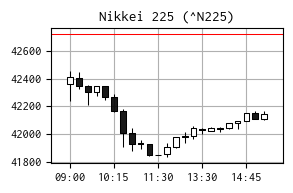

In [63]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()